1- Setting groundtruth and queries


In [1]:
import xml.etree.ElementTree as ET
import matplotlib as plt
import pandas as pd
import numpy as np
import trec
import pprint as pp
import pickle

Qrels = "qrels-clinical_trials.txt"

Queries = "topics-2014_2015-summary.topics"


with open(Queries, 'r') as queries_reader:
    txt = queries_reader.read()

root = ET.fromstring(txt)

cases = {}
cases_age = {}
cases_genre = {}
for query in root.iter('TOP'):
    q_num = query.find('NUM').text
    q_title = query.find('TITLE').text
    cases[q_num] = q_title
    cases_age[q_num] = query.find('AGE').text
    cases_genre[q_num] = query.find('GENDER').text

eval = trec.TrecEvaluation(cases, Qrels)

pickle.dump(cases, open("cases.bin", "wb"))
pickle.dump(cases_age, open("cases_age.bin", "wb"))
pickle.dump(cases_genre, open("cases_genre.bin", "wb"))


2 -Getting Clinical trials info


In [4]:
import xml.etree.ElementTree as ET
import tarfile

tar = tarfile.open("clinicaltrials.gov-16_dec_2015.tgz", "r:gz")
doc_ids = []
brief_titles = []
detailed_descriptions = []
brief_summaries = []
criterias = []
genders = []
minimum_ages = []
maximum_ages = []

namelist = tar.getnames()

for tarinfo in tar:
    if tarinfo.size > 500:
        txt = tar.extractfile(tarinfo).read().decode("utf-8", "strict")
        root = ET.fromstring(txt)
        judged = False
        id=''
        bt=''
        dt=''
        bs=''
        cs=''
        ge=''
        ma=''
        mi=''

        for doc_id in root.iter('nct_id'):
            if doc_id.text in eval.judged_docs:
                judged = True
                id=doc_id.text.strip()
                break
                
        if judged is False:
            continue

        brief_title = root.find('brief_title').text.strip()
        bt=brief_title

        for dd in root.iter('detailed_description'):
            for child in dd:
                dd=child.text.strip()
        if dd == '':
            dd=brief_title
              
        for bs in root.iter('brief_summary'):
            for child in bs:
                bs=child.text.strip()
        if bs == '':
            bs=brief_title
                
        for c in root.iter('criteria'):
            for child in c:
                cs=child.text.strip()
        if cs=='':
            cs= brief_title

        for gender in root.iter('gender'):
            ge=gender.text.strip()
        if ge=='' or ge=='N/A':
            ge='Both'

        for minimum_age in root.iter('minimum_age'):
            mi=minimum_age.text.strip()
        if mi=='' or mi=='N/A':
            mi='0 years'

        for maximum_age in root.iter('maximum_age'):
            ma=maximum_age.text.strip()
        if ma=='' or ma=='N/A':
            ma='100 years'

       
        if id!='' and bt!='' and dd!='' and bs!='' and cs!='' and ge!='' and mi!='' and ma!='':
            doc_ids.append(id)
            brief_titles.append(bt)
            detailed_descriptions.append(dd)
            brief_summaries.append(bs)
            criterias.append(cs)
            genders.append(ge)
            minimum_ages.append(mi)
            maximum_ages.append(ma)
            #print('passed')
        else:
            print('failed')
            print(id,bt,dd,bs,cs)
            continue

        if len(doc_ids) != len(brief_titles) or len(detailed_descriptions) != len(brief_summaries) or len(brief_summaries) != len(criterias):
            print("error")
            print(brief_title)
            print(detailed_descriptions[0].text.strip())
            print(brief_summaries[0].text.strip())
            print(criterias[0].text.strip())
            break
tar.close()

print('ids',len(doc_ids))
print('bt', len(brief_titles))
print('dd',len(detailed_descriptions))
print('bs',len(brief_summaries))
print('c',len(criterias))
print('g', len(genders))
print('mina',len(minimum_ages))
print('maa',len(maximum_ages))

pickle.dump(doc_ids, open("doc_ids.bin", "wb"))
pickle.dump(brief_titles, open("brief_title.bin", "wb"))
pickle.dump(detailed_descriptions, open("detailed_description.bin", "wb"))
pickle.dump(brief_summaries, open("brief_summary.bin", "wb"))
pickle.dump(criterias, open("criteria.bin", "wb"))
pickle.dump(genders, open("gender.bin", "wb"))
pickle.dump(minimum_ages, open("minimum_age.bin", "wb"))
pickle.dump(maximum_ages, open("maximum_age.bin", "wb"))


ids 3626
bt 3626
dd 3626
bs 3626
c 3626
g 3626
mina 3626
maa 3626


3 -Defining abstract class RetrievalModel


In [2]:
import abc  # é preciso importar isto quando queremos definir uma classe abstrata


class RetrievalModel:  # vamos criar uma classe abstrata que é o molde para todas as nossas classes, cada uma um modelo
    @abc.abstractmethod  # para sabermos que RetrievalModel é uma classe abstrata e que, portanto, não pode ser instanciada, ie, "concretizada"
    def search(self):  # aqui nomeia-se uma das funcoes desta classe, neste caso, aquela onde vamos por o codigo q ordenava os docs e ainda classificava a performance do nosso modelo (junto para nao termos q mudar tanto o codigo)
        pass  # nao se pode por nada aqui na abstrata, apenas em cada classe "filho" é que se define a função, aqui apenas se nomeia


4-VSM Unigram


In [3]:
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.feature_extraction.text import TfidfVectorizer


class VSM(RetrievalModel):  # definimos a classe de um dos modelos e pomos o RetrievalModel para dizer q esta classe é uma subclasse da classe abstrata
    def search(self, caseid, docs):  # aqui definimos a funcao que faz tudo o q o nosso modelo fazia, pus o codigo ca dentro, pus self.doc em vez de docs
        index = TfidfVectorizer(ngram_range=(
            1, 1), analyzer='word', stop_words=None)
        index.fit(docs)
        X = index.transform(docs)
        query = cases[caseid]
        query_tfidf = index.transform([query])
        doc_scores = 1-pairwise_distances(X, query_tfidf, metric='cosine')
        scores = doc_scores.tolist()
        return scores


5-LMJM Unigram


In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import pairwise_distances
from collections import Counter

brief_summary = pickle.load(open("brief_summary.bin", "rb"))

# print(cases)


class LMJM(RetrievalModel):
    def search(self, caseid, docs):
        index = CountVectorizer(ngram_range=(1, 1), analyzer='word')
        corpus_cv = index.fit(docs).transform(docs)
        lmbd = 0.8
        prob_word_docs = corpus_cv/np.sum(corpus_cv, axis=1)  # p(t|md)
        prob_word_corpus = np.sum(corpus_cv, axis=0) / \
            np.sum(corpus_cv)  # p(t|mc)
        log_mixture = np.log(lmbd*prob_word_docs + (1-lmbd)*prob_word_corpus)
        query = cases[caseid]
        query_cv = index.transform([query])
        total = log_mixture*query_cv.T
        return total


6-Import relevant documents and libraries


In [49]:
import pickle
import trec
import numpy as np

# Aqui abrimos cada documento pickle e damos-lhes os nomes para usar nas funcoes seguintes
ids = pickle.load(open("doc_ids.bin", "rb"))
brief_title = pickle.load(open("brief_title.bin", "rb"))
detailed_description = pickle.load(open("detailed_description.bin", "rb"))
brief_summary = pickle.load(open("brief_summary.bin", "rb"))
criteria = pickle.load(open("criteria.bin", "rb"))
gender = pickle.load(open("gender.bin", "rb"))
minimum_age = pickle.load(open("minimum_age.bin", "rb"))
maximum_age = pickle.load(open("maximum_age.bin", "rb"))
cases = pickle.load(open("cases.bin", "rb"))
genders = pickle.load(open("gender.bin", "rb"))
minimum_ages = pickle.load(open("minimum_age.bin", "rb"))
maximum_ages = pickle.load(open("maximum_age.bin", "rb"))


7-Setting models and text fields


In [6]:
models = [VSM(), LMJM()]
fields = [brief_title, detailed_description, brief_summary, criteria]

8-Separate training and test queries


In [7]:
print("cases length: ", len(cases))
cases_training = []
cases_test = []
i = 0
k = 12
for caseid in cases:
    if i < len(cases)-k:
        cases_training.append(caseid)
    else:
        cases_test.append(caseid)
    i += 1

print("training queries length: ", len(cases_training))
print("test queries length: ", len(cases_test))


cases length:  60
training queries length:  48
test queries length:  12


9-Getting scores for pairs query_doc for each model and text field


In [8]:
# buscar listas
queries_training = []
docs_training = []
VSM_bt_training = []
VSM_dd_training = []
VSM_bs_training = []
VSM_cr_training = []
LMJM_bt_training = []
LMJM_dd_training = []
LMJM_bs_training = []
LMJM_cr_training = []
y_training = []

for caseid in cases_training:
    case_rel = []
    field_ind = 0
    aux = eval.relevance_judgments.loc[eval.relevance_judgments['query_id'] == int(
        caseid)]
    docs = aux['docid'].tolist()
    for docid in docs:
        case_rel.append(ids.index(docid))
    relevances = aux['rel'].tolist()
    for rel in relevances:
        if rel == 0:
            y_training.append(rel)
        elif rel == 1 or rel == 2:
            y_training.append(1)
    for model in models:
        for field in fields:
            scores = model.search(caseid, field)
            for rel in case_rel:
                value = scores[rel]
                if field_ind == 0:
                    queries_training.append(caseid)
                    docs_training.append(rel)
                    VSM_bt_training.append(value[0])
                elif field_ind == 1:
                    VSM_dd_training.append(value[0])
                elif field_ind == 2:
                    VSM_bs_training.append(value[0])
                elif field_ind == 3:
                    VSM_cr_training.append(value[0])
                elif field_ind == 4:
                    LMJM_bt_training.append(value[0])
                elif field_ind == 5:
                    LMJM_dd_training.append(value[0])
                elif field_ind == 6:
                    LMJM_bs_training.append(value[0])
                elif field_ind == 7:
                    LMJM_cr_training.append(value[0])
            field_ind += 1

print("VSM_brief_title_training: ", len(VSM_bt_training))
print("VSM_detailed_description_training: ", len(VSM_dd_training))
print("VSM_brief_summary_training: ", len(VSM_bs_training))
print("VSM_criteria_training: ", len(VSM_cr_training))
print("LMJM_brief_title_training: ", len(LMJM_bt_training))
print("LMJM_detailed_description_training: ", len(LMJM_dd_training))
print("LMJM_brief_summary_training: ", len(LMJM_bs_training))
print("LMJM_criteria_training: ", len(LMJM_cr_training))
print("y_training: ", len(y_training))


VSM_brief_title_training:  3296
VSM_detailed_description_training:  3296
VSM_brief_summary_training:  3296
VSM_criteria_training:  3296
LMJM_brief_title_training:  3296
LMJM_detailed_description_training:  3296
LMJM_brief_summary_training:  3296
LMJM_criteria_training:  3296
y_training:  3296


10- Normalize scores and create dataframe

In [20]:
#normalize
VSM_bt_training_norm = [(float(i)-min(VSM_bt_training))/(max(VSM_bt_training)-min(VSM_bt_training)) for i in VSM_bt_training]
VSM_dd_training_norm = [(float(i)-min(VSM_dd_training))/(max(VSM_dd_training)-min(VSM_dd_training)) for i in VSM_dd_training]
VSM_bs_training_norm = [(float(i)-min(VSM_bs_training))/(max(VSM_bs_training)-min(VSM_bs_training)) for i in VSM_bs_training]
VSM_cr_training_norm = [(float(i)-min(VSM_cr_training))/(max(VSM_cr_training)-min(VSM_cr_training)) for i in VSM_cr_training]
LMJM_bt_training_norm = [(float(i)-min(LMJM_bt_training))/(max(LMJM_bt_training)-min(LMJM_bt_training)) for i in LMJM_bt_training]
LMJM_dd_training_norm = [(float(i)-min(LMJM_dd_training))/(max(LMJM_dd_training)-min(LMJM_dd_training)) for i in LMJM_dd_training]
LMJM_bs_training_norm = [(float(i)-min(LMJM_bs_training))/(max(LMJM_bs_training)-min(LMJM_bs_training)) for i in LMJM_bs_training]
LMJM_cr_training_norm = [(float(i)-min(LMJM_cr_training))/(max(LMJM_cr_training)-min(LMJM_cr_training)) for i in LMJM_cr_training]

candidates = {'query': queries_training,
              'doc': docs_training,
              'VSM_bt': VSM_bt_training_norm,
              'VSM_dd': VSM_dd_training_norm,
              'VSM_bs': VSM_bs_training_norm,
              'VSM_cr': VSM_cr_training_norm,
              'LMJM_bt': LMJM_bt_training_norm,
              'LMJM_dd': LMJM_dd_training_norm,
              'LMJM_bs': LMJM_bs_training_norm,
              'LMJM_cr': LMJM_cr_training_norm,
              'Y': y_training
              }
df = pd.DataFrame(candidates, columns=['query', 'doc',
                                       'VSM_bt', 'VSM_dd', 'VSM_bs', 'VSM_cr', 'LMJM_bt', 'LMJM_dd', 'LMJM_bs', 'LMJM_cr', 'Y'])


11-Logistic Regression cross validation to find best C


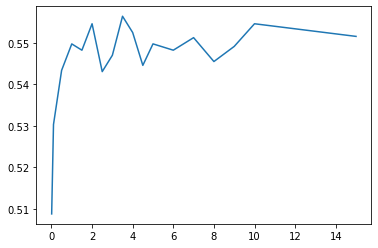

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
#from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

x = df[['VSM_bt', 'VSM_dd', 'VSM_bs', 'VSM_cr',
        'LMJM_bt', 'LMJM_dd', 'LMJM_bs', 'LMJM_cr']]
y = df['Y']
c_values = [0.01, 0.1, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 6,7,8,9 ,10, 15]
c_ap = []
k = 5
kf = KFold(n_splits=k, random_state=None, shuffle=True)

for c in c_values:
    acc_score = []
    for train_index, test_index in kf.split(x):
        X_train, X_test = x.iloc[train_index, :], x.iloc[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
        clf = LogisticRegression(
            random_state=0, C=c, class_weight='balanced').fit(X_train, y_train)
        pred_values = clf.predict(X_test)
        acc = accuracy_score(pred_values, y_test)
        acc_score.append(acc)
    avg_acc_score = sum(acc_score)/k
    c_ap.append(avg_acc_score)

plt.plot(c_values, c_ap)


11-Training Logistic Regression with best C value


In [12]:
clf = LogisticRegression(
    random_state=0, C=2, class_weight='balanced').fit(x, y)
coefs = clf.coef_[0]
print('Coefs: {}'.format(coefs))

Coefs: [-0.66321698 -0.03321505 -0.51703492 -0.26911082  0.00534964 -0.01012452
  0.00412697  0.00276404]


12-Eval scores for docs that are judged for a given test query:


In [44]:
p10_list = []
recall_list = []
ap_list = []
ndcg5_list = []
mrr_list = []

for caseid in cases_test:
    VSM_bt_test = []
    VSM_dd_test = []
    VSM_bs_test = []
    VSM_cr_test = []
    LMJM_bt_test = []
    LMJM_dd_test = []
    LMJM_bs_test = []
    LMJM_cr_test = []
    y_test = []
    case_rel = []
    field_ind = 0
    zs = []
    aux = eval.relevance_judgments.loc[eval.relevance_judgments['query_id'] == int(
        caseid)]
    docs = aux['docid'].tolist()
    relevances = aux['rel'].tolist()
    for rel in relevances:
        if rel == 0:
            y_test.append(rel)
        elif rel == 1 or rel == 2:
            y_test.append(1)
    for docid in docs:
        case_rel.append(ids.index(docid))
    for model in models:
        for field in fields:
            scores = model.search(caseid, field)
            for rel in case_rel:
                value = scores[rel]
                if field_ind == 0:
                    VSM_bt_test.append(value[0])
                elif field_ind == 1:
                    VSM_dd_test.append(value[0])
                elif field_ind == 2:
                    VSM_bs_test.append(value[0])
                elif field_ind == 3:
                    VSM_cr_test.append(value[0])
                elif field_ind == 4:
                    LMJM_bt_test.append(value[0])
                elif field_ind == 5:
                    LMJM_dd_test.append(value[0])
                elif field_ind == 6:
                    LMJM_bs_test.append(value[0])
                elif field_ind == 7:
                    LMJM_cr_test.append(value[0])
            field_ind += 1
            
    for line in range(0, len(VSM_bt_test)):
        z = coefs[0]*VSM_bt_test[line]+coefs[1]*VSM_dd_test[line] + coefs[2]*VSM_bs_test[line]+coefs[3]*VSM_cr_test[line] + \
            coefs[4]*LMJM_bt_test[line]+coefs[5]*LMJM_dd_test[line] + \
            coefs[6]*LMJM_bs_test[line]+coefs[7]*LMJM_cr_test[line]
        zs.append(z)

    doc_ids = []
    for pos in case_rel:
        doc_ids.append(ids[pos])

    cand = {'_id': doc_ids, 'score': zs}
    results = pd.DataFrame(cand, columns=['_id', 'score'])
    results.sort_values(by=['score'], inplace=True, ascending=False)
    [p10, recall, ap, ndcg5, mrr] = eval.eval(results, caseid)
    [precision_11point, recall_11point,
        total_relv_ret] = eval.evalPR(results, caseid)

    p10_list += [p10]
    recall_list += [recall]
    ap_list += [ap]
    ndcg5_list += [ndcg5]
    mrr_list += [mrr]

print("Scores of relevant docs for test cases:")
print("P10", np.mean(p10_list))
print("Recall", np.mean(recall_list))
print("AP", np.mean(ap_list))
print("NDCG5", np.mean(ndcg5_list))
print("MRR", np.mean(mrr_list))


Scores of relevant docs for test cases:
P10 0.17500000000000002
Recall 1.0
AP 0.24794054532156182
NDCG5 0.12713573123234226
MRR 0.2150800309473823


13-Eval scores for all docs given test queries


In [45]:
p10_list = []
recall_list = []
ap_list = []
ndcg5_list = []
mrr_list = []

avg_precision_11point = np.zeros(11)

for caseid in cases_test:
    VSM_bt_test = []
    VSM_dd_test = []
    VSM_bs_test = []
    VSM_cr_test = []
    LMJM_bt_test = []
    LMJM_dd_test = []
    LMJM_bs_test = []
    LMJM_cr_test = []
    field_ind = 0
    zs = []
    for model in models:
        for field in fields:
            scores = model.search(caseid, field)
            for id in range(0, len(ids)):
                value = scores[id]
                if field_ind == 0:
                    VSM_bt_test.append(value[0])
                elif field_ind == 1:
                    VSM_dd_test.append(value[0])
                elif field_ind == 2:
                    VSM_bs_test.append(value[0])
                elif field_ind == 3:
                    VSM_cr_test.append(value[0])
                elif field_ind == 4:
                    LMJM_bt_test.append(value[0])
                elif field_ind == 5:
                    LMJM_dd_test.append(value[0])
                elif field_ind == 6:
                    LMJM_bs_test.append(value[0])
                elif field_ind == 7:
                    LMJM_cr_test.append(value[0])
            field_ind += 1

    for line in range(0, len(VSM_bt_test)):
        z = coefs[0]*VSM_bt_test[line]+coefs[1]*VSM_dd_test[line] + coefs[2]*VSM_bs_test[line]+coefs[3]*VSM_cr_test[line] + \
            coefs[4]*LMJM_bt_test[line]+coefs[5]*LMJM_dd_test[line] + \
            coefs[6]*LMJM_bs_test[line]+coefs[7]*LMJM_cr_test[line]
        zs.append(z)

    cand = {'_id': ids, 'score': zs}
    results = pd.DataFrame(cand, columns=['_id', 'score'])
    results.sort_values(by=['score'], inplace=True, ascending=False)

    [p10, recall, ap, ndcg5, mrr] = eval.eval(results, caseid)
    [precision_11point, recall_11point,
        total_relv_ret] = eval.evalPR(results, caseid)

    p10_list += [p10]
    recall_list += [recall]
    ap_list += [ap]
    ndcg5_list += [ndcg5]
    mrr_list += [mrr]

print("Scores of all docs for test cases:")
print("P10", np.mean(p10_list))
print("Recall", np.mean(recall_list))
print("AP", np.mean(ap_list))
print("NDCG5", np.mean(ndcg5_list))
print("MRR", np.mean(mrr_list))


Scores of all docs for test cases:
P10 0.025000000000000005
Recall 1.0
AP 0.009947245714695598
NDCG5 0.014131591792902345
MRR 0.003125574554145983


14-Eval scores for all docs given test queries with filters


In [50]:
q_age = []
d_min_age = []
d_max_age = []


for case in cases_age:
    #print(case)
    q_age.append(cases_age[case].split(' ')[0])

for case in minimum_ages:
    d_min_age.append(case.split(' ')[0])

for case in maximum_ages:
    d_max_age.append(case.split(' ')[0])



In [61]:
p10_list = []
recall_list = []
ap_list = []
ndcg5_list = []
mrr_list = []

avg_precision_11point = np.zeros(11)
j=0
for caseid in cases_test:
    new_ids = []
    VSM_bt_test = []
    VSM_dd_test = []
    VSM_bs_test = []
    VSM_cr_test = []
    LMJM_bt_test = []
    LMJM_dd_test = []
    LMJM_bs_test = []
    LMJM_cr_test = []
    field_ind = 0
    zs = []
    for model in models:
        for field in fields:
            scores = model.search(caseid, field)
            for id in range(0, len(ids)-1):
                # filters
                if int(q_age[j]) <= int(d_max_age[id]) and int(q_age[j]) >= int(d_min_age[id]) and (cases_genre[caseid] == genders[id] or genders[id] == 'Both'):
                    value = scores[id]
                    if field_ind == 0:
                        VSM_bt_test.append(value[0])
                        new_ids.append(ids[id])
                    elif field_ind == 1:
                        VSM_dd_test.append(value[0])
                    elif field_ind == 2:
                        VSM_bs_test.append(value[0])
                    elif field_ind == 3:
                        VSM_cr_test.append(value[0])
                    elif field_ind == 4:
                        LMJM_bt_test.append(value[0])
                    elif field_ind == 5:
                        LMJM_dd_test.append(value[0])
                    elif field_ind == 6:
                        LMJM_bs_test.append(value[0])
                    elif field_ind == 7:
                        LMJM_cr_test.append(value[0])
            field_ind += 1
    j+=1

    for line in range(0, len(VSM_bt_test)):
        z = coefs[0]*VSM_bt_test[line]+coefs[1]*VSM_dd_test[line] + coefs[2]*VSM_bs_test[line]+coefs[3]*VSM_cr_test[line] + \
            coefs[4]*LMJM_bt_test[line]+coefs[5]*LMJM_dd_test[line] + \
            coefs[6]*LMJM_bs_test[line]+coefs[7]*LMJM_cr_test[line]
        zs.append(z)

    cand = {'_id': new_ids, 'score': zs}
    results = pd.DataFrame(cand, columns=['_id', 'score'])
    results.sort_values(by=['score'], inplace=True, ascending=False)

    [p10, recall, ap, ndcg5, mrr] = eval.eval(results, caseid)
    [precision_11point, recall_11point,
        total_relv_ret] = eval.evalPR(results, caseid)

    p10_list += [p10]
    recall_list += [recall]
    ap_list += [ap]
    ndcg5_list += [ndcg5]
    mrr_list += [mrr]

print("Scores of all docs for test cases:")
print("P10", np.mean(p10_list))
print("Recall", np.mean(recall_list))
print("AP", np.mean(ap_list))
print("NDCG5", np.mean(ndcg5_list))
print("MRR", np.mean(mrr_list))


Scores of all docs for test cases:
P10 0.025000000000000005
Recall 0.6296230158730158
AP 0.010658768831191935
NDCG5 0.014131591792902345
MRR 0.0036069555020501205
